## APPLE STOCK PRICE PREDICTION

In [62]:
#Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
# Machine Learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
# For ARIMA
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

## DATA LOAD

In [63]:

# symbol = "AAPL"   # Example: Apple Inc.
# start_date = "2015-01-01"
# end_date = datetime.today().strftime("%Y-%m-%d")

# df = yf.download(symbol, start=start_date, end=end_date)

# # Save a local CSV cache
# df.to_csv("stock_data_new.csv")
df=pd.read_csv("stock_data_new.csv") 



In [64]:
print("Data Shape:", df.shape)


Data Shape: (2676, 6)


In [65]:
print(df.head())

         Date      Close       High        Low       Open     Volume
0  02-01-2015  24.261047  24.729270  23.821672  24.718174  212818400
1  05-01-2015  23.577562  24.110138  23.391162  24.030252  257142000
2  06-01-2015  23.579796  23.839426  23.218087  23.641929  263188400
3  07-01-2015  23.910431  24.010288  23.677428  23.788382  160423600
4  08-01-2015  24.829123  24.886819  24.121240  24.238852  237458000


## PREPROCESSING

In [66]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y", errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["Date"])

In [67]:
# Handle non-trading days -> already handled by Yahoo Finance
# Outlier handling (IQR method)
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Close'] >= Q1 - 1.5*IQR) & (df['Close'] <= Q3 + 1.5*IQR)]

print("After Preprocessing Shape:", df.shape)

After Preprocessing Shape: (2676, 6)


## Visualization

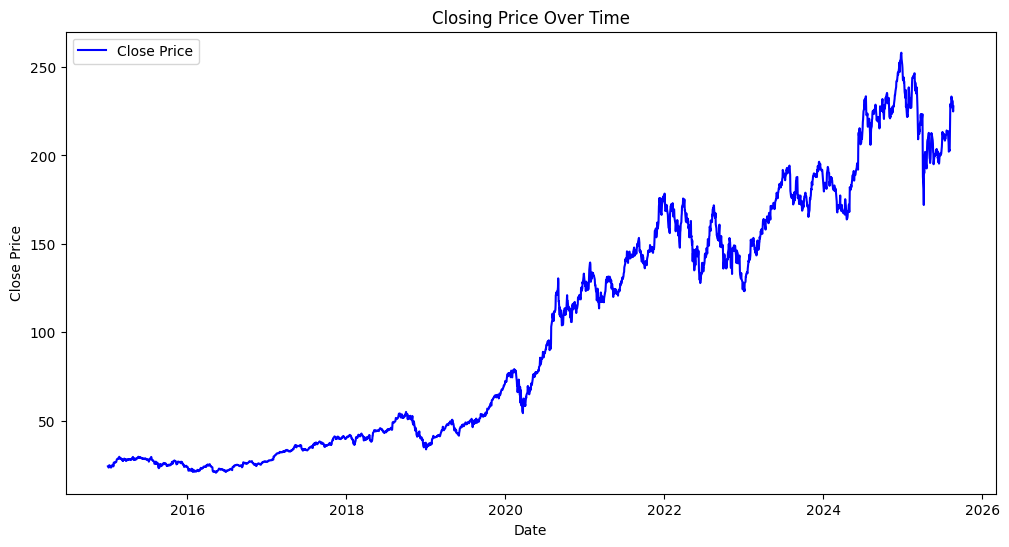

In [70]:
#1. Closing Price Trend
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Close Price", color="blue")
plt.title("Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

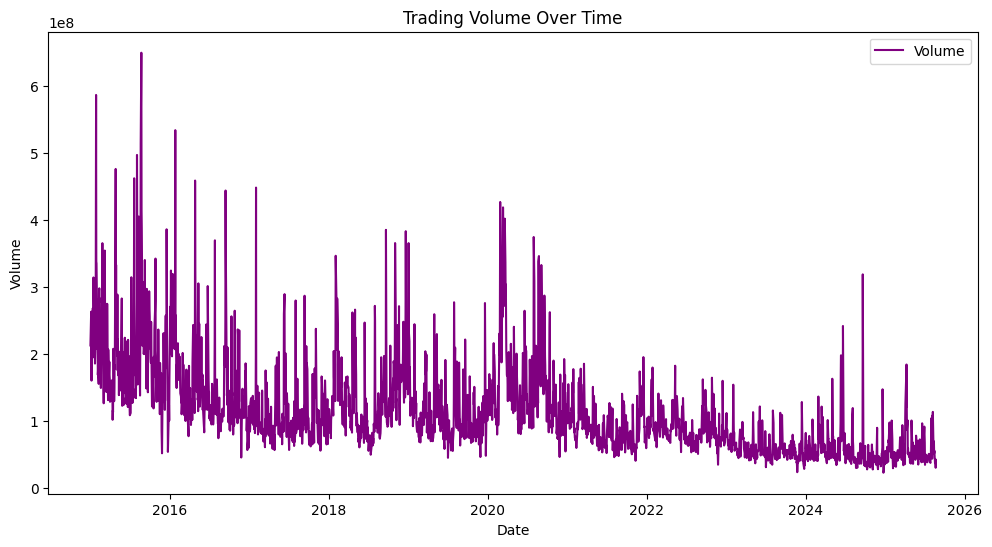

In [71]:
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Volume"], label="Volume", color="purple")
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.show()


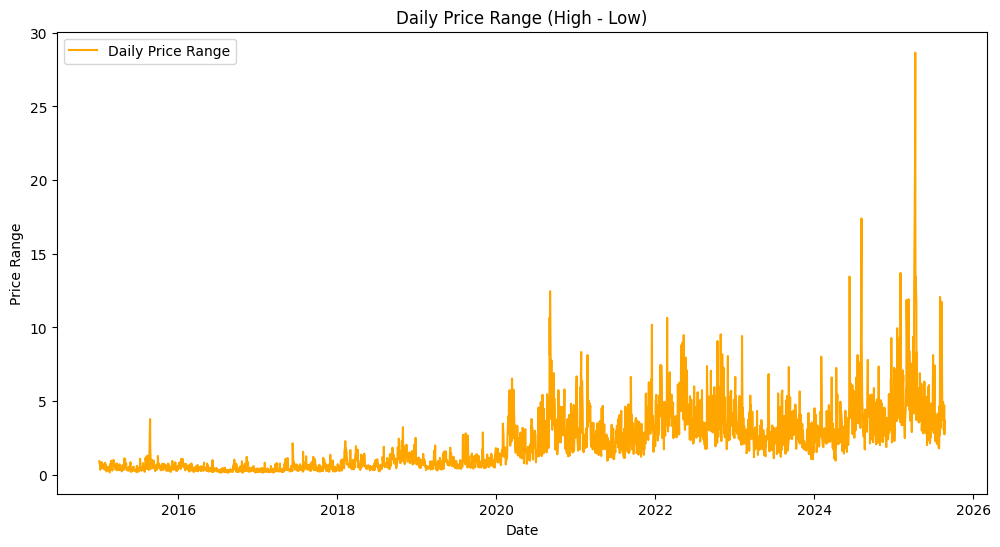

In [72]:

# 3. Daily Price Range (High - Low)
df["Range"] = df["High"] - df["Low"]
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Range"], label="Daily Price Range", color="orange")
plt.title("Daily Price Range (High - Low)")
plt.xlabel("Date")
plt.ylabel("Price Range")
plt.legend()
plt.show()


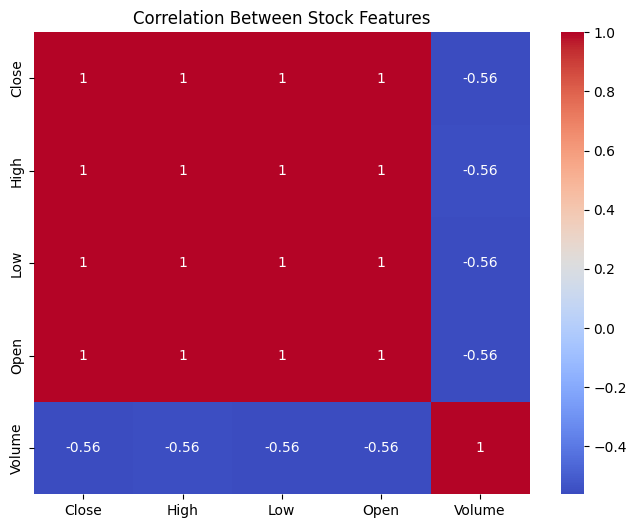

In [73]:

# 4. Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[["Close","High","Low","Open","Volume"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Stock Features")
plt.show()



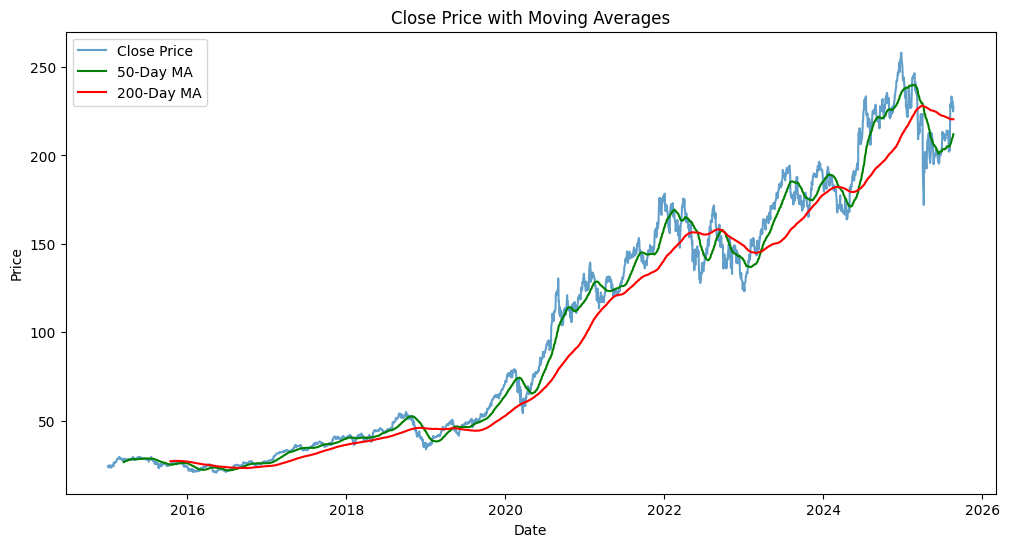

In [74]:
# 5. Moving Averages (Short vs Long Term)
df["MA50"] = df["Close"].rolling(50).mean()
df["MA200"] = df["Close"].rolling(200).mean()

plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Close Price", alpha=0.7)
plt.plot(df["Date"], df["MA50"], label="50-Day MA", color="green")
plt.plot(df["Date"], df["MA200"], label="200-Day MA", color="red")
plt.title("Close Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

## Feature Engeneering


In [75]:
# Moving Averages
df['MA_20'] = df['Close'].rolling(20).mean()
df['MA_50'] = df['Close'].rolling(50).mean()

# RSI Calculation
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Fill NaN
df.fillna(method="bfill", inplace=True)

print(df[['Close','MA_20','MA_50','RSI']].head())

       Close      MA_20      MA_50        RSI
0  24.261047  24.552076  26.612772  56.613501
1  23.577562  24.552076  26.612772  56.613501
2  23.579796  24.552076  26.612772  56.613501
3  23.910431  24.552076  26.612772  56.613501
4  24.829123  24.552076  26.612772  56.613501


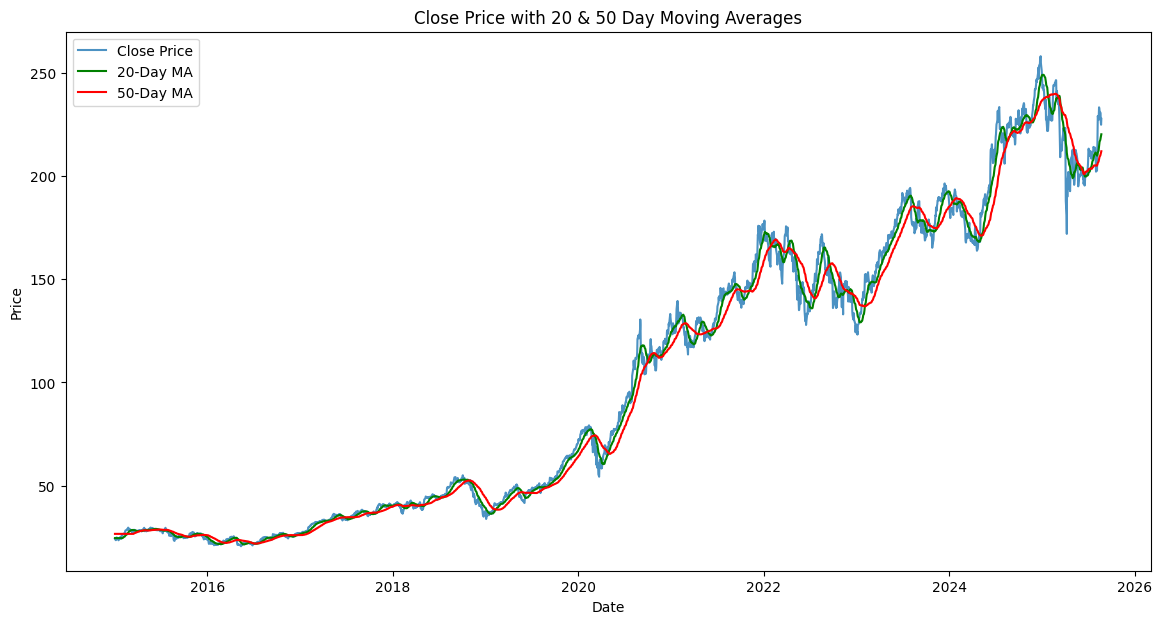

In [76]:
# 1. Plot Close Price with Moving Averages
plt.figure(figsize=(14,7))
plt.plot(df["Date"], df["Close"], label="Close Price", alpha=0.8)
plt.plot(df["Date"], df["MA_20"], label="20-Day MA", color="green")
plt.plot(df["Date"], df["MA_50"], label="50-Day MA", color="red")
plt.title("Close Price with 20 & 50 Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()



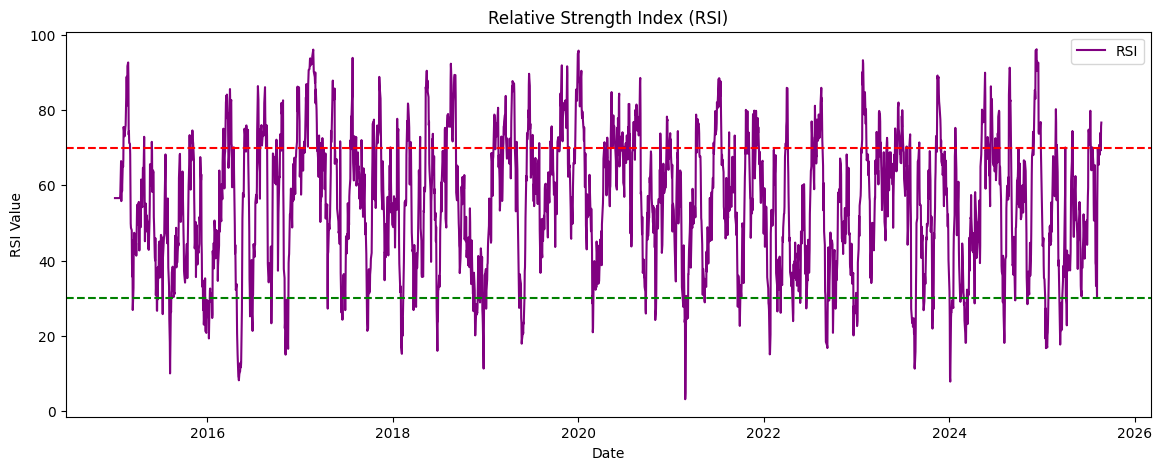

In [77]:
# 2. Plot RSI
plt.figure(figsize=(14,5))
plt.plot(df["Date"], df["RSI"], label="RSI", color="purple")
plt.axhline(70, color="red", linestyle="--")   # Overbought threshold
plt.axhline(30, color="green", linestyle="--") # Oversold threshold
plt.title("Relative Strength Index (RSI)")
plt.xlabel("Date")
plt.ylabel("RSI Value")
plt.legend()
plt.show()

## Prepare ML model

In [78]:
X = df[['Open','High','Low','Volume','MA_20','MA_50','RSI']]
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## Linear Regression

In [80]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)



## Decision Tree

In [81]:

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

## Random Forest

In [82]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [83]:
print("\nModel Performance:")
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Decision Tree R2:", r2_score(y_test, y_pred_dt))


Model Performance:
Linear Regression R2: 0.9975151437710615
Random Forest R2: -0.21832354607133042
Decision Tree R2: -0.2605792677563321


## ARIMA Model

In [84]:

close_prices = df['Close']

arima_model = ARIMA(close_prices, order=(5,1,0))  # simple ARIMA
arima_fit = arima_model.fit()

## Forecast until 2027-12-25

In [85]:

last_date = df['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end="2027-12-25")

forecast = arima_fit.forecast(steps=len(future_dates))

forecast_df = pd.DataFrame({"Date": future_dates, "Forecast_ARIMA": forecast.values})

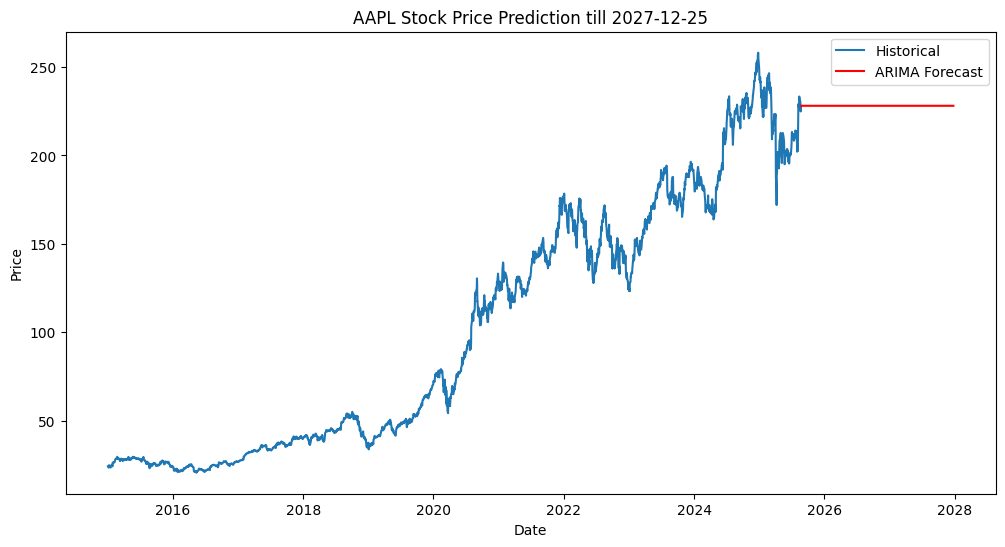

In [86]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label="Historical")
plt.plot(forecast_df['Date'], forecast_df['Forecast_ARIMA'], color='red', label="ARIMA Forecast")
plt.title(f"{symbol} Stock Price Prediction till 2027-12-25")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [92]:

target_date = pd.to_datetime("2027-12-25")

# --- ML Models need features ---
future_df = pd.DataFrame({
    "Date": [target_date],
    "Open": [df['Close'].iloc[-1]],   # assume next day's open ~ last close
    "High": [df['Close'].iloc[-1]],
    "Low": [df['Close'].iloc[-1]],
    "Close": [df['Close'].iloc[-1]],
    "Volume": [df['Volume'].iloc[-1]]
})

# Add technical indicators same as training
future_df['MA_20'] = df['Close'].rolling(20).mean().iloc[-1]
future_df['MA_50'] = df['Close'].rolling(50).mean().iloc[-1]

# RSI calculation for last available window
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean().iloc[-1]
avg_loss = loss.rolling(14).mean().iloc[-1]
rs = avg_gain / avg_loss if avg_loss != 0 else 0
rsi = 100 - (100 / (1 + rs))
future_df['RSI'] = rsi

# Select features
future_features = future_df[X.columns]

# ML Predictions
pred_lr = lr.predict(future_features)[0]
pred_rf = rf.predict(future_features)[0]
pred_dt = dt.predict(future_features)[0]

# ARIMA Prediction for target date
arima_pred = forecast_df.loc[forecast_df['Date'] == target_date, 'Forecast_ARIMA'].values[0]


print("\n==============================")
print(f"Last Known Price on {last_date.date()}: {df['Close'].iloc[-1]:.2f}")
print(f"Predictions for {target_date.date()}:")
print(f"Linear Regression : {pred_lr:.2f}")
print(f"Random Forest     : {pred_rf:.2f}")
print(f"Decision Tree     : {pred_dt:.2f}")
print(f"ARIMA Forecast    : {arima_pred:.2f}")
print("==============================")



Last Known Price on 2025-08-22: 227.76
Predictions for 2027-12-25:
Linear Regression : 227.70
Random Forest     : 189.88
Decision Tree     : 189.22
ARIMA Forecast    : 228.10
